In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
# Funcion para seleccion de la ROI del objeto a seguir

# se seleccionan los vertices opuestos del rectangulo del objeto a seleccionar

def selectROI(event,x,y,flags,param):
    global frame, mode, click
    if mode and event == cv.EVENT_LBUTTONDOWN and len(RoiPts) < 2 :
        RoiPts.append((x,y))
        cv.circle(frame, (x,y), 4, (0,255,0), 2)
        cv.imshow("frame",frame)
        if(len(RoiPts)==2):
            print(RoiPts[:])
            mode = False
        

### DEFINICION DE LA ROI

In [4]:
def Def_Roi(frame,RoiPts):
    
    global track_window
    # Definimos la ubicación de la ventana de seguimiento
    #-----------------------------------------------------------
    # r,h,c,w - Región de la imagen
    x, y = RoiPts[0]
    x2,y2 = RoiPts[1]

    w = abs(x2 - x)
    h = abs(y2 - y) 
    track_window = (x, y, w, h)

    # Una vez definida la ROI recortamos esa parte de la imagen que utilizaremos para seguimiento
    #--------------------------------------------------------------------------------------------
    roi = frame[y:y+h, x:x+w]
    # Pasamos la ROI a HSV (los valores de H son más estables a cambios de intensidad)
    hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
    # Definimos una máscara para el histograma (Hue: 0..180, Saturation:60..255, Value:32..255)
    mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
    # Y calculamos el histograma sobre esa máscara (toma solo el Hue: tonalidad)
    roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
    # Normalizamos el histograma (entre 0 y 255 según indica el flag cv.NORM_MINMAX)
    cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

    # Mostramos lo que se fue armando en relación a la ROI
    #-----------------------------------------------------
    plt.figure()
    plt.imshow(mask)

    # Muestro la imagen como para ver dónde definimos la ROI
    #-------------------------------------------------------
    frame_roi = cv.cvtColor(roi, cv.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(frame_roi)

    
    return roi_hist

[(488, 249), (550, 344)]


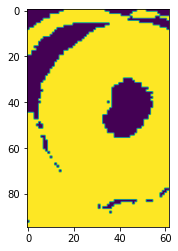

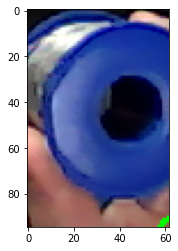

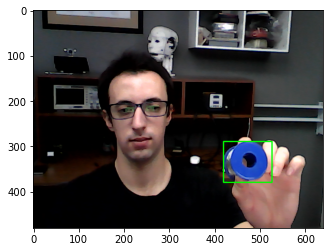

In [7]:
camera = cv.VideoCapture(0)
mode = True# modo seleccion de ROI
RoiPts = list()
Not_Def_Roi = True
frame_flag = True

# Condición de terminación: 10 iteraciones o moverse al menos 1pt
#----------------------------------------------------------------
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 1, 10 )

# Pulsar 's' para salir 
while(1):
    ret,frame = camera.read()
    cv.namedWindow('frame')
    cv.setMouseCallback('frame', selectROI)
    
    k = cv.waitKey(60) & 0xff
    if k == 27:
        break
    if mode == False and Not_Def_Roi:
        roi_hist = Def_Roi(frame,RoiPts)
        Not_Def_Roi = False
    
    if mode == True:
        cv.putText(frame, 'Seleccione vertices opuestos para def. la ROI', (100,400),cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv.LINE_AA)
        cv.imshow('frame',frame)
    
    else:
        # Si la ROI fue seleccionada Aplicamos camshift
        
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        # Aplicamos camshift al nuevo frame
        #----------------------------------
        ret, track_window = cv.CamShift(dst, track_window, term_crit)
        x,y,w,h = track_window
        frame = cv.rectangle(frame, (x,y), (x+w,y+h), (0,255,0),2)
        cv.imshow('frame',frame)
        f = frame
        
        
plt.figure()
plt.imshow(f[:,:,::-1])
cv.destroyAllWindows()
camera.release()